In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys
import os

# --- PyTorch and Sklearn Imports --
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

# --- TensorFlow for Data Loading ONLY --
import tensorflow as tf

# --- CRITICAL FIX v2: Isolate TensorFlow to CPU without hiding the GPU from PyTorch ---
try:
    physical_devices = tf.config.list_physical_devices()
    cpus = [d for d in physical_devices if d.device_type == 'CPU']
    tf.config.set_visible_devices(cpus)
    print("✅ TensorFlow successfully configured to use CPU only.")

    # --- VERIFICATION STEP ---
    if not tf.config.list_physical_devices('GPU'):
        print("   - Confirmed: TensorFlow does not see the GPU.")
    else:
        print("   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.")

    if torch.cuda.is_available():
        print("✅ PyTorch can see and use the GPU.")
        print(f"   - GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("   - ❌ CRITICAL WARNING: PyTorch cannot see the GPU. Training will be on CPU.")

except Exception as e:
    print(f"An error occurred during device configuration: {e}")


warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory
DATA_DIR = Path("/kaggle/input/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# --- CORRECTED TFRecord PARSING FUNCTION --
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    """
    feature_description = {}

    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]

    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)

    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

print("\n✅ Setup complete!")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ TensorFlow successfully configured to use CPU only.
   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.
✅ PyTorch can see and use the GPU.
   - GPU Device Name: Tesla P100-PCIE-16GB
📁 Data directory: /kaggle/input/ndws_western_dataset
📂 Directory exists: True

✅ Setup complete!


In [2]:
# --- UPDATED VISUALIZATION FUNCTION (WITH SAVE CAPABILITY) ---

def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4, save_path=None):
    """
    Visualize fire prediction results and optionally save the plot to a file.
    """
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]

    with torch.no_grad():
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()

    # <<< NEW: Save the figure if a path is provided >>>
    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"✅ Visualization saved to '{save_path}'")
        except Exception as e:
            print(f"⚠️ Could not save visualization. Error: {e}")

    plt.show() # Display the plot after saving

    # Return the prediction statistics so they can be saved to the results file
    stats = {
        "true_fire_pixels": np.sum(y_test_subset > 0.1),
        "predicted_fire_pixels": np.sum(predictions > 0.5),
        "average_prediction_confidence": np.mean(predictions)
    }

    # Print statistics to the notebook
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {stats['true_fire_pixels']}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {stats['predicted_fire_pixels']}")
    print(f"📈 Average prediction confidence: {stats['average_prediction_confidence']:.4f}")

    return stats

# --- NEW FUNCTION TO SAVE ALL RESULTS TO A TEXT FILE ---
def save_results_to_file(model_name, cv_results, viz_stats, file_path="model_results.txt"):
    """
    Saves the cross-validation and visualization statistics for a model to a text file.
    """
    mean_ap = np.mean(cv_results)
    std_ap = np.std(cv_results)

    try:
        with open(file_path, 'a') as f: # 'a' for append mode
            f.write("="*70 + "\n")
            f.write(f"MODEL: {model_name}\n")
            f.write("="*70 + "\n\n")

            f.write("--- Cross-Validation Summary ---\n")
            f.write(f"Mean Average Precision (AP): {mean_ap:.4f} ± {std_ap:.4f}\n")
            f.write(f"Individual Fold AP Scores: {[f'{score:.4f}' for score in cv_results]}\n\n")

            if viz_stats:
                f.write("--- Visualization Sample Statistics ---\n")
                f.write(f"True Fire Pixels: {viz_stats['true_fire_pixels']}\n")
                f.write(f"Predicted Fire Pixels (>0.5): {viz_stats['predicted_fire_pixels']}\n")
                f.write(f"Average Prediction Confidence: {viz_stats['average_prediction_confidence']:.4f}\n\n\n")

        print(f"✅ Results for '{model_name}' appended to '{file_path}'")
    except Exception as e:
        print(f"⚠️ Could not save results to file. Error: {e}")

print("✅ Visualization and results-saving functions are ready!")

✅ Visualization and results-saving functions are ready!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH Swin-Unet ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 106 input features** as spatial inputs
- ✅ **Swin-Unet architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The data pipeline remains identical to the previous versions. The core change is the model architecture, which now uses Swin Transformer blocks for both the encoder and decoder.

In [3]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        # Load all daily snapshots into one list
        for file_path in tfrecord_files:
            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
                    break
            else: continue
            break
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC ---
        spatial_inputs, spatial_targets = [], []
        # Total window size = num_timesteps (past env) + 1 (current day) + 1 (target day)
        sequence_len = self.num_timesteps + 2
        
        for i in range(len(all_samples_flat) - sequence_len):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            # Define the time windows
            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps] # t-4 to t-1
            current_day_sample = all_samples_flat[i + self.num_timesteps]              # day 't'
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]           # day 't+1'

            # --- Assemble the Input Tensor (X) ---
            input_features = []
            
            # 1. Add the fire mask from the CURRENT day (t)
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))

            # 2. Add environmental features from the PAST days (t-4 to t-1)
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            
            # 3. Add environmental features from the CURRENT day (t)
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            # --- Assemble the Target Tensor (y) ---
            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# --- DATASET CLASS AND NORMALIZATION (UNCHANGED FROM PREVIOUS NOTEBOOKS) ---
import random
from torch.utils.data import Dataset, SubsetRandomSampler

class WildfireDataset(Dataset):
    """
    PyTorch Dataset for loading wildfire sequences "just-in-time" from TFRecords.
    This avoids loading the entire dataset into memory.
    """
    def __init__(self, data_dir, num_timesteps=4, max_sequences=None, normalization_stats=None):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps
        self.normalization_stats = normalization_stats
        self.sequence_len = self.num_timesteps + 2 # Total daily records needed for one sequence

        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population', 'impervious', 'water',
            'tmp_day', 'tmp_75', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust', 'gust_med',
            'avg_sph', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3'
        ]

        print("🔥 Initializing WildfireDataset: Building sequence index...")
        self.tfrecord_files = sorted(list(self.data_dir.glob("*.tfrecord")))
        self.index = self._build_index()

        if max_sequences is not None and max_sequences < len(self.index):
            print(f" M Randomly sampling {max_sequences} sequences from the full dataset.")
            self.index = random.sample(self.index, max_sequences)

        print(f"✅ Index created. Dataset contains {len(self.index)} sequences.")

    def _build_index(self):
        """ Scans TFRecords and creates a master list of all valid sequence start points. """
        index = []
        for file_path in self.tfrecord_files:
            # Get the total number of records in the file quickly
            num_records = sum(1 for _ in tf.data.TFRecordDataset(str(file_path)))

            # A sequence can start at 'i' if there are enough records after it
            for i in range(num_records - self.sequence_len + 1):
                index.append((str(file_path), i)) # Store (filepath, record_offset)
        return index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """ Loads and processes a single sequence from disk on demand. """
        file_path, record_offset = self.index[idx]

        # Use tf.data to efficiently skip to the required records
        dataset = tf.data.TFRecordDataset(file_path)
        raw_records = dataset.skip(record_offset).take(self.sequence_len)

        # Load the small set of daily samples needed for this one sequence
        daily_samples = []
        for raw_record in raw_records:
            parsed_sample = parse_tfrecord_flexible(raw_record)
            sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
            daily_samples.append(sample_data)

        # --- Assemble the Input and Target Tensors (same logic as before) ---
        past_environmental_sequence = daily_samples[0 : self.num_timesteps]
        current_day_sample = daily_samples[self.num_timesteps]
        next_day_sample = daily_samples[self.num_timesteps + 1]

        input_features = []
        input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
        for past_sample in past_environmental_sequence:
            for feature_name in self.environmental_features:
                if feature_name in past_sample:
                    input_features.append(past_sample[feature_name].reshape(64, 64, 1))
        for feature_name in self.environmental_features:
             if feature_name in current_day_sample:
                input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))
        
        # Concatenate and transpose for PyTorch (C, H, W)
        x = np.concatenate(input_features, axis=2).astype(np.float32)
        x = np.transpose(x, (2, 0, 1))

        # Get target mask and transpose
        y = next_day_sample['viirs_FireMask'].reshape(64, 64, 1).astype(np.float32)
        y = (np.transpose(y, (2, 0, 1)) > 0.1).astype(np.float32)

        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)

        # Apply normalization if stats are provided
        if self.normalization_stats is not None:
            means = self.normalization_stats['means']
            stds = self.normalization_stats['stds']
            x_tensor = (x_tensor - means) / stds

        return x_tensor, y_tensor

def calculate_normalization_stats(dataset, num_samples=500):
    """ Calculates mean and std for normalization on a subset of the data. """
    print(f"📊 Calculating normalization statistics on {num_samples} random samples...")

    num_samples = min(num_samples, len(dataset))
    sampler = SubsetRandomSampler(random.sample(range(len(dataset)), num_samples))
    loader = DataLoader(dataset, batch_size=32, sampler=sampler, num_workers=2)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for inputs, _ in tqdm(loader, desc="Calculating Stats"):
        channels_sum += torch.mean(inputs, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(inputs**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    std[std == 0] = 1

    stats = {'means': mean.reshape(-1, 1, 1), 'stds': std.reshape(-1, 1, 1)}
    print("✅ Normalization stats calculated.")
    return stats

In [5]:
# --- PYTORCH SWIN-UNET ARCHITECTURE (FINAL VERIFIED), LOSS, AND TRAINING FUNCTION ---

# --- HELPER MODULES FOR SWIN TRANSFORMER ---
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm
import numpy as np
import os

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size * window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))
        coords_h = torch.arange(window_size[0]); coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size[0] - 1
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(N, N, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must be in [0, window_size)"
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(dim, to_2tuple(self.window_size), num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        if self.shift_size > 0: shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else: shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0: x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else: x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm, downsample=None):
        super().__init__()
        self.blocks = nn.ModuleList([SwinTransformerBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size, shift_size=0 if (i % 2 == 0) else window_size // 2, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop, attn_drop=attn_drop, drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path, norm_layer=norm_layer) for i in range(depth)])
        self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer) if downsample is not None else nn.Identity()

    def forward(self, x):
        for blk in self.blocks: x = blk(x)
        x = self.downsample(x)
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=3, embed_dim=96, norm_layer=nn.LayerNorm):
        super().__init__()
        self.img_size = to_2tuple(img_size)
        self.patch_size = to_2tuple(patch_size)
        self.patches_resolution = [self.img_size[0] // self.patch_size[0], self.img_size[1] // self.patch_size[1]]
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer is not None else nn.Identity()

    def forward(self, x):
        return self.norm(self.proj(x).flatten(2).transpose(1, 2))

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        x = x.view(B, H, W, C)
        x = torch.cat([x[:, 0::2, 0::2, :], x[:, 1::2, 0::2, :], x[:, 0::2, 1::2, :], x[:, 1::2, 1::2, :]], -1)
        x = self.norm(x.view(B, -1, 4 * C))
        x = self.reduction(x)
        return x

class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False)
        self.norm = norm_layer(dim // 2)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c_out) -> b (h p1) (w p2) c_out', p1=2, p2=2, c_out=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)
        return x

class SwinUnet(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=106, num_classes=1,
                 embed_dim=96, depths=[2, 2, 2], num_heads=[3, 6, 12],
                 window_size=4, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        patches_resolution = self.patch_embed.patches_resolution
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        
        # --- Encoder ---
        self.encoder_layers = nn.ModuleList()
        num_layers = len(depths)
        for i_layer in range(num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                input_resolution=(patches_resolution[0] // (2**i_layer), patches_resolution[1] // (2**i_layer)),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < num_layers - 1) else None
            )
            self.encoder_layers.append(layer)

        # --- Bottleneck ---
        self.bottleneck = BasicLayer(
            dim=int(embed_dim * 2**(num_layers-1)),
            input_resolution=(patches_resolution[0] // (2**(num_layers-1)), patches_resolution[1] // (2**(num_layers-1))),
            depth=depths[-1],
            num_heads=num_heads[-1],
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            drop=drop_rate,
            attn_drop=attn_drop_rate,
            drop_path=dpr[sum(depths[:-1]):],
            norm_layer=norm_layer,
            downsample=None
        )

        # --- START OF FIX: Corrected Decoder Initialization and Skip Logic ---
        self.decoder_layers = nn.ModuleList()
        # The number of upsampling stages must equal the number of downsampling stages (num_layers - 1)
        for i_layer in reversed(range(num_layers - 1)):
            # Determine the dimensions for the current decoder stage
            in_dim = int(embed_dim * 2**(i_layer + 1))
            skip_dim = int(embed_dim * 2**i_layer)
            out_dim = skip_dim
            concat_dim = skip_dim + (in_dim // 2)

            # The input resolution for PatchExpand is the output resolution of the deeper layer
            expand_input_res = (patches_resolution[0] // (2**(i_layer + 1)), patches_resolution[1] // (2**(i_layer + 1)))

            upsample_layer = PatchExpand(
                input_resolution=expand_input_res,
                dim=in_dim
            )
            
            concat_linear = nn.Linear(concat_dim, out_dim, bias=False)
            
            # The input resolution for the Swin blocks is the resolution after upsampling
            stage_input_res = (expand_input_res[0] * 2, expand_input_res[1] * 2)

            decoder_stage = BasicLayer(
                dim=out_dim,
                input_resolution=stage_input_res,
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                downsample=None
            )
            self.decoder_layers.append(nn.ModuleList([upsample_layer, concat_linear, decoder_stage]))
        # --- END OF FIX ---

        # --- Final Output Head ---
        self.final_norm = norm_layer(embed_dim)
        self.final_conv = nn.Conv2d(embed_dim, num_classes, kernel_size=1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None: nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        
        encoder_skips = []
        for layer in self.encoder_layers:
            encoder_skips.append(x)
            x = layer(x)

        x = self.bottleneck(x)

        # --- START OF FIX: Corrected Skip Connection Logic ---
        # The decoder stages are indexed in reverse order of the encoder stages they connect to
        for i, (upsample, concat, decoder_stage) in enumerate(self.decoder_layers):
            x = upsample(x)
            # Connect to the corresponding encoder skip connection
            # The deepest skip is from the second-to-last encoder stage
            skip = encoder_skips[len(self.encoder_layers) - 2 - i]
            x = torch.cat([x, skip], -1)
            x = concat(x)
            x = decoder_stage(x)
        # --- END OF FIX ---
            
        x = self.final_norm(x)
        B, L, C = x.shape
        H, W = self.patch_embed.patches_resolution
        x = x.transpose(-1, -2).contiguous().view(B, C, H, W)
        
        x = F.interpolate(x, size=self.patch_embed.img_size, mode='bilinear', align_corners=False)
        x = self.final_conv(x)
        return torch.sigmoid(x)

# --- LOSS FUNCTION (UNCHANGED) ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight
    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# --- GENERIC TRAINING FUNCTION (UNCHANGED) ---
def train_fire_model_cv_pytorch(dataset, model_class, model_args, n_splits=5, epochs=20, batch_size=4, checkpoint_path="model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_gpu = torch.cuda.is_available()
    print(f"🚀 INITIATING TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None
    start_fold = 0
    checkpoint = None

    if os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=False)
            start_fold = checkpoint.get('fold', 0)
            if checkpoint.get('epoch', -1) == epochs - 1: start_fold += 1
            fold_ap_scores = checkpoint.get('fold_ap_scores', [])
            if start_fold > 0 and start_fold < n_splits:
                print(f"🔄 Resuming training from fold {start_fold + 1}")
        except Exception as e:
            print(f"⚠️ Could not load checkpoint: {e}. Starting from scratch.")
            checkpoint = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        if fold < start_fold: continue

        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=use_gpu)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=use_gpu)

        model = model_class(**model_args).to(device)
        criterion = BCEDiceLoss(weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        start_epoch = 0
        if checkpoint is not None and fold == checkpoint.get('fold', -1):
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint.get('epoch', 0) + 1
                if start_epoch < epochs:
                    print(f"🔄 Resuming fold {fold+1} from epoch {start_epoch + 1}")
            except Exception as e:
                print(f"⚠️ Could not load state dicts from checkpoint: {e}. Starting fold from scratch.")
                start_epoch = 0

        print(f"🔥 STARTING TRAINING...")
        for epoch in range(start_epoch, epochs):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
                loss.backward(); optimizer.step()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

            torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'fold_ap_scores': fold_ap_scores}, checkpoint_path)

        model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.cpu().numpy().flatten())
        
        if len(np.concatenate(all_labels)) > 0 and len(np.unique(np.concatenate(all_labels))) > 1:
            ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
            if len(fold_ap_scores) <= fold: fold_ap_scores.append(ap_score)
            else: fold_ap_scores[fold] = ap_score
            print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        else:
            print(f"⚠️ Fold {fold + 1} Validation - Could not compute AP. Not enough class diversity in labels.")

        last_model = model
        checkpoint = None 

    print("\n\n📊 CROSS-VALIDATION SUMMARY"); print("=" * 60)
    if fold_ap_scores: print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    if last_model:
        model_save_path = f"final_{model.__class__.__name__.lower()}.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from last fold saved to '{model_save_path}'")
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
            print(f"🗑️ Removed temporary checkpoint file: '{checkpoint_path}'")

    return last_model, fold_ap_scores

🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 1 sequences from the full dataset.
✅ Index created. Dataset contains 1 sequences.
✅ Model configured: SwinUnet with 106 input channels.

--- Step 1: Preparing Dataset ---
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 5000 sequences from the full dataset.
✅ Index created. Dataset contains 5000 sequences.
📊 Calculating normalization statistics on 2000 random samples...


Calculating Stats:   0%|          | 0/63 [00:00<?, ?it/s]

✅ Normalization stats calculated.
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 5000 sequences from the full dataset.
✅ Index created. Dataset contains 5000 sequences.

--- Step 2: Training SwinUnet ---
🚀 INITIATING TRAINING ON cuda WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)
🔄 Resuming training from fold 3

========== FOLD 3/3 ==========
🔄 Resuming fold 3 from epoch 23
🔥 STARTING TRAINING...


Epoch 23/25:   0%|          | 0/834 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/834 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/834 [00:00<?, ?it/s]

Validating:   0%|          | 0/417 [00:00<?, ?it/s]

✅ Fold 3 Validation - AP: 0.1231


📊 CROSS-VALIDATION SUMMARY
  - Mean AP ± Std Dev: 0.1111 ± 0.0129

💾 Final model from last fold saved to 'final_swinunet.pth'
🗑️ Removed temporary checkpoint file: 'swinunet_checkpoint.pth'

🎉 SwinUnet TRAINING COMPLETED!

--- Step 3: Generating Visualizations and Saving Results for SwinUnet ---
✅ Visualization saved to 'swinunet_predictions.png'


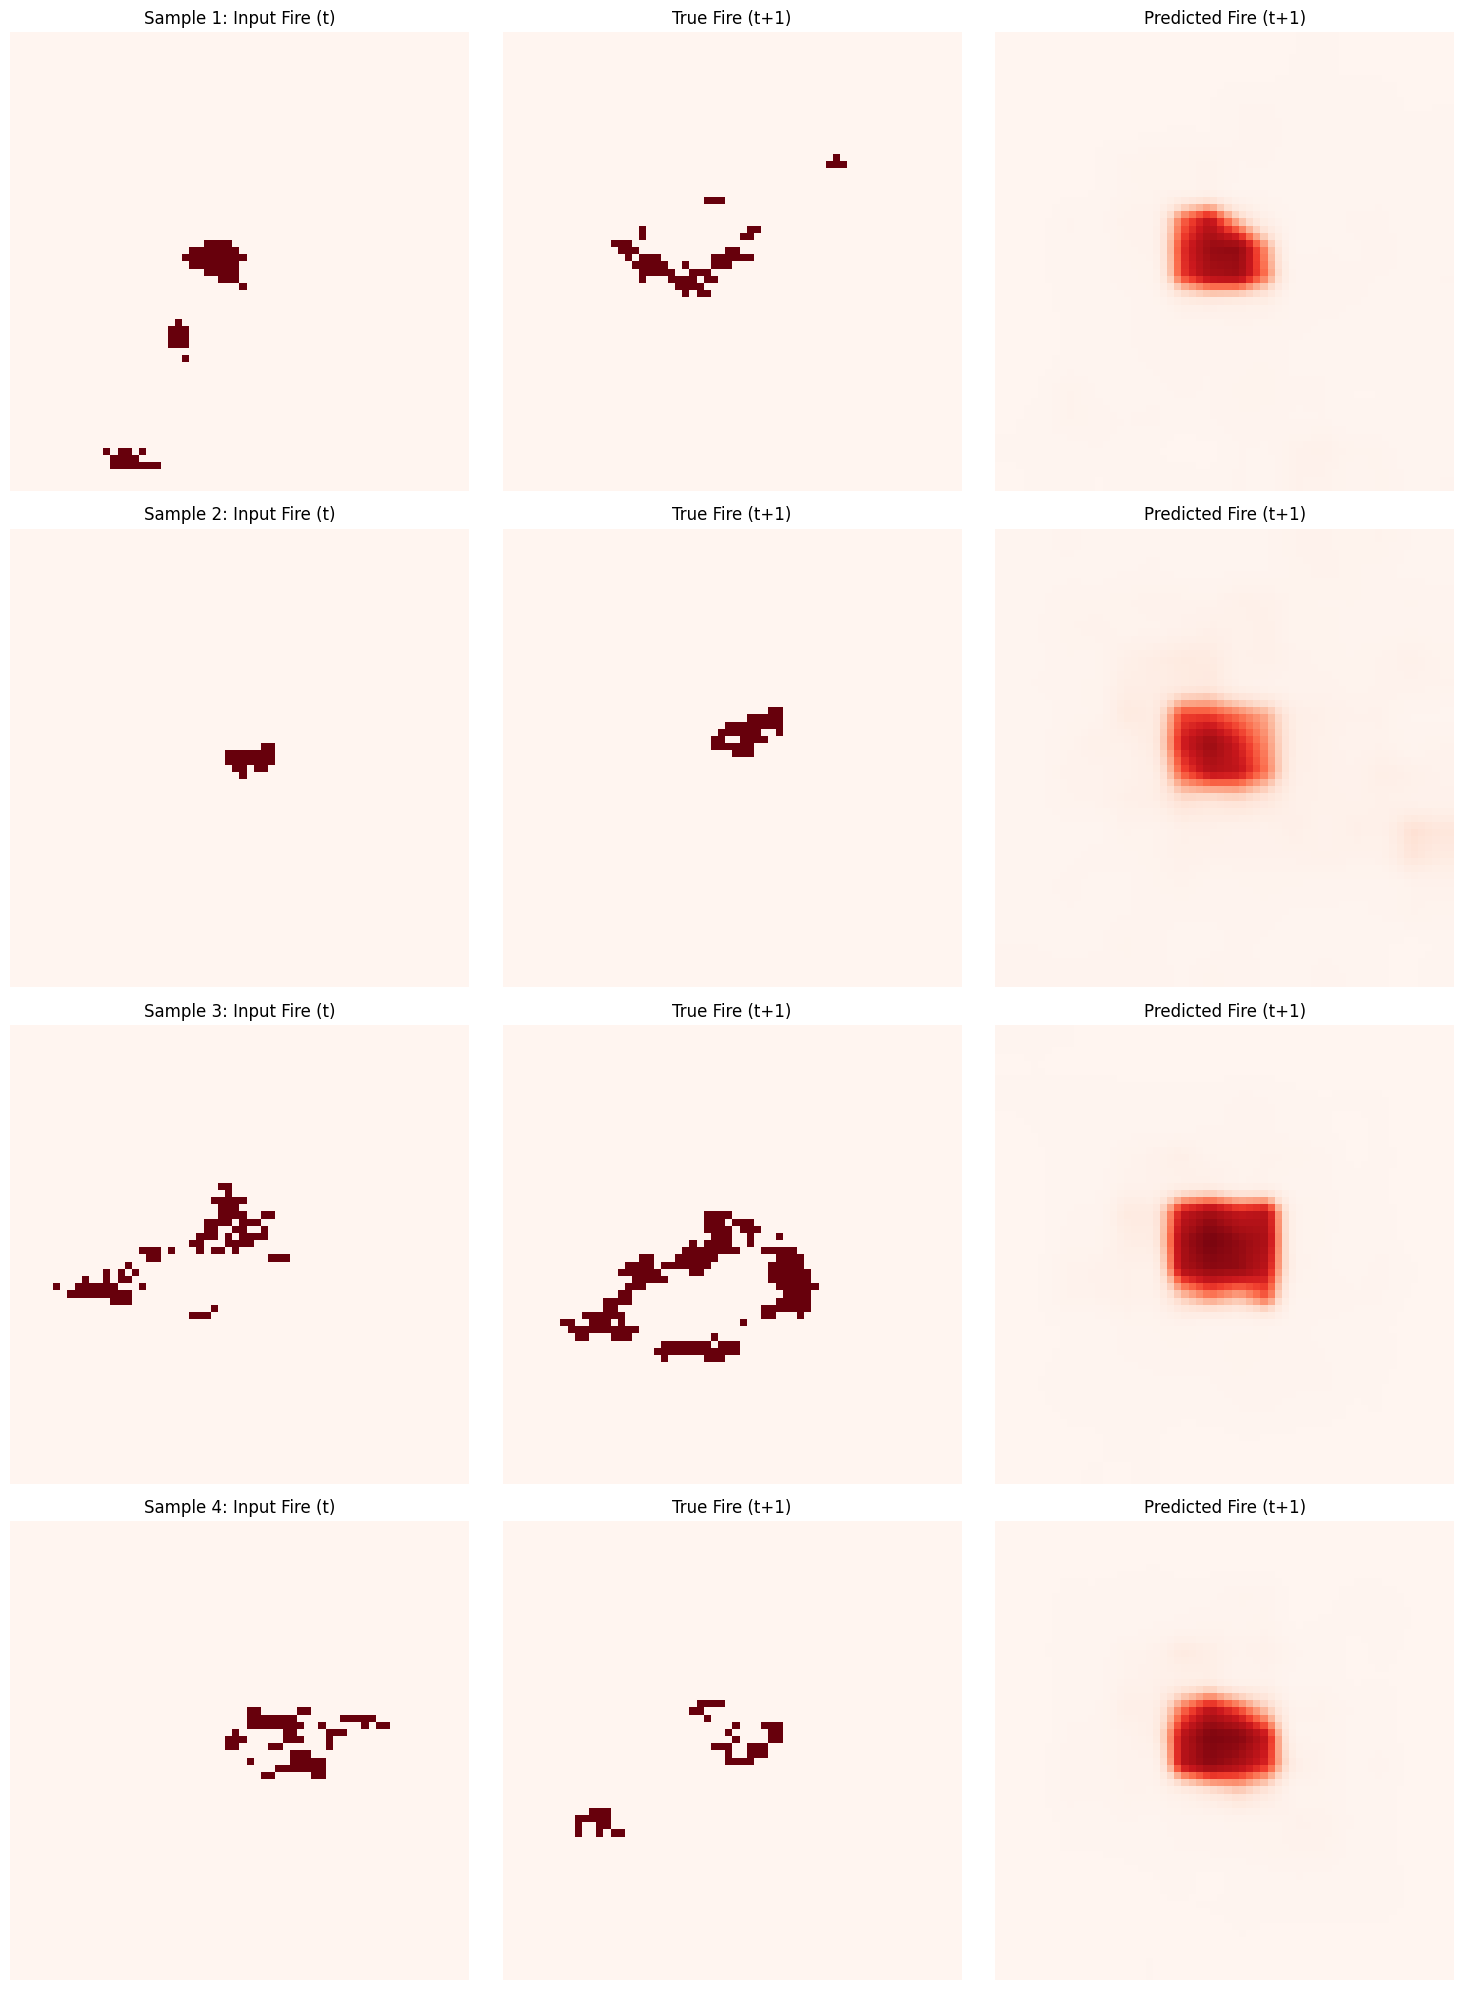


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 330
🎯 Predicted fire pixels (threshold > 0.5): 496
📈 Average prediction confidence: 0.0396
✅ Results for 'SwinUnet' appended to 'model_results.txt'


In [6]:
# --- EXECUTION FOR THE COMBINED TIME-SERIES MODEL WITH SWIN-UNET ---

# --- MODEL CONFIGURATION ---
model_name = "SwinUnet"
checkpoint_file = "swinunet_checkpoint.pth"

# Get the number of input channels from a sample item
sample_x, _ = WildfireDataset(data_dir=DATA_DIR, max_sequences=1)[0]
num_input_channels = sample_x.shape[0]

# Define the arguments for the SwinUnet model (a "tiny" configuration)
swinunet_args = {
    'img_size': 64,
    'patch_size': 4,
    'in_chans': num_input_channels,
    'num_classes': 1,
    'embed_dim': 96, # Starting dimension
    'depths': [2, 2, 2], # Blocks per encoder/decoder stage
    'num_heads': [3, 6, 12],
    'window_size': 4,
    'mlp_ratio': 4.
}
print(f"✅ Model configured: {model_name} with {num_input_channels} input channels.")


# 1. Initialize the Dataset (without loading all data into RAM)
print("\n--- Step 1: Preparing Dataset ---")
temp_dataset = WildfireDataset(data_dir=DATA_DIR, num_timesteps=4, max_sequences=5000)
normalization_stats = calculate_normalization_stats(temp_dataset, num_samples=2000)

full_dataset = WildfireDataset(
    data_dir=DATA_DIR,
    num_timesteps=4,
    max_sequences=5000,
    normalization_stats=normalization_stats
)

# 2. Train the Swin-Unet model
final_model_swinunet = None
cv_results_swinunet = []
viz_stats_swinunet = None

if len(full_dataset) > 0:
    print(f"\n--- Step 2: Training {model_name} ---")

    final_model_swinunet, cv_results_swinunet = train_fire_model_cv_pytorch(
        dataset=full_dataset,
        model_class=SwinUnet,
        model_args=swinunet_args,
        n_splits=3,
        epochs=25,
        batch_size=4,
        checkpoint_path=checkpoint_file
    )

    if cv_results_swinunet:
        print(f"\n🎉 {model_name} TRAINING COMPLETED!")
    else:
        print(f"❌ {model_name} training failed or was interrupted!")
else:
    print(f"❌ Cannot train model - dataset is empty!")

# 3. Visualization and Saving Results
if final_model_swinunet is not None:
    print(f"\n--- Step 3: Generating Visualizations and Saving Results for {model_name} ---")

    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    _, val_indices = list(kfold.split(full_dataset))[-1]

    num_viz_samples = min(4, len(val_indices))
    if num_viz_samples > 0:
        viz_inputs, viz_targets = [], []
        for i in range(num_viz_samples):
            x, y = full_dataset[val_indices[i]]
            viz_inputs.append(np.transpose(x.numpy(), (1, 2, 0))) # H, W, C
            viz_targets.append(np.transpose(y.numpy(), (1, 2, 0)))

        X_test_norm = np.array(viz_inputs)
        y_test_binary = np.array(viz_targets)

        viz_stats_swinunet = visualize_fire_predictions_pytorch(
            final_model_swinunet, X_test_norm, y_test_binary, num_samples=num_viz_samples, save_path="swinunet_predictions.png"
        )
        
        save_results_to_file(model_name, cv_results_swinunet, viz_stats_swinunet)

    else:
        print("Not enough validation samples to visualize.")

else:
    print(f"\n⚠️ {model_name} model not available for evaluation.")